In [1]:
from sqlalchemy import create_engine
import pandas as pd

# Connexion PostgreSQL
user = 'postgres'
password = 'sarra'
host = 'localhost'
port = '5432'
database = 'DWHF'

connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'
conn = create_engine(connection_string)



In [2]:
query = """
SELECT 
    dd."date_PK" AS hire_date
FROM "fact_Employibilite" fe
JOIN "dim_date" dd ON fe."First_job_Date_FK" = dd."date_PK"
WHERE dd."date_PK" IS NOT NULL
  AND dd."date_PK" >= '2015-01-01';
"""

✅ Nombre de mois disponibles : 117


C:\Users\Acer\venv_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Acer\venv_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Acer\venv_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Acer\venv_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Acer\ve

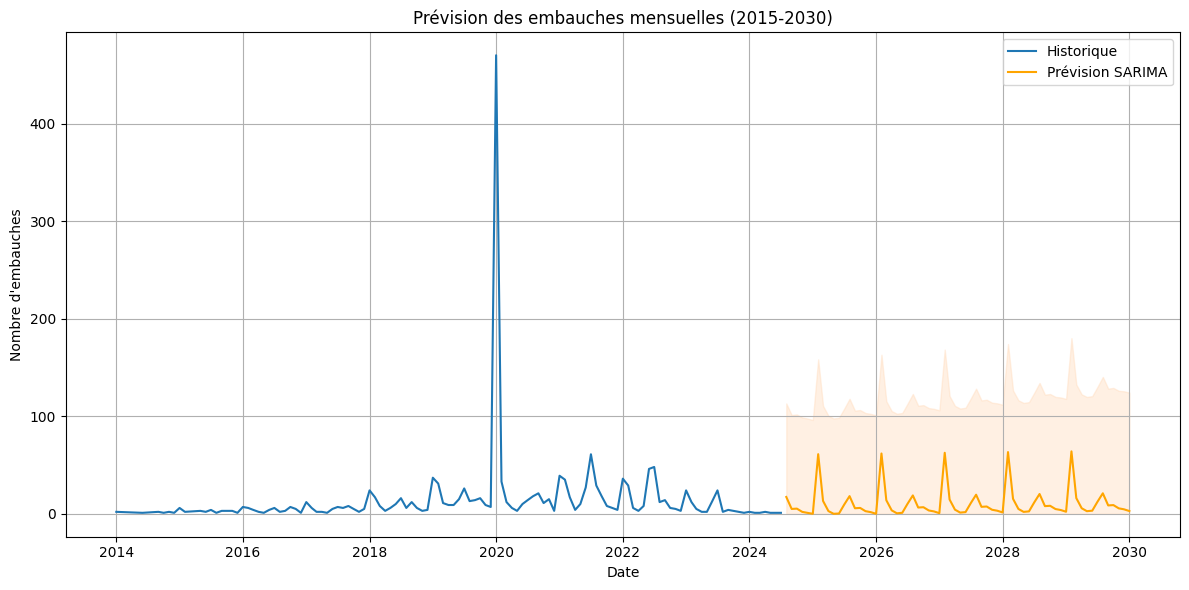

        Date  Prévision  Borne Inf   Borne Sup
0 2024-08-01  17.241347        0.0  113.112447
1 2024-09-01   4.964077        0.0  101.213595
2 2024-10-01   5.297516        0.0  101.788843
3 2024-11-01   1.965785        0.0   98.695999
4 2024-12-01   0.979875        0.0   97.693223
5 2025-01-01   0.000000        0.0   96.150831
6 2025-02-01  61.111366        0.0  158.299980
7 2025-03-01  13.202481        0.0  110.625911
8 2025-04-01   2.793940        0.0  100.451630
9 2025-05-01   0.000000        0.0   97.683687


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sqlalchemy import create_engine

# 📦 Connexion PostgreSQL
user = 'postgres'
password = 'sarra'
host = 'localhost'
port = '5432'
database = 'DWHF'
connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'
conn = create_engine(connection_string)

# 📥 Requête SQL avec full_date
query = """
SELECT 
    dd."full_date" AS hire_date
FROM "fact_employability" fe
JOIN "dim_date" dd ON fe."First_job_Date_FK" = dd."Date_PK"
WHERE dd."full_date" IS NOT NULL
  AND dd."full_date" >= '2014-01-01';
"""

# 📄 Lecture des données
df = pd.read_sql(query, conn)
conn.dispose()

# 📅 Préparation des données temporelles
df['hire_month'] = pd.to_datetime(df['hire_date']).dt.to_period('M').dt.to_timestamp()
df_grouped = df.groupby('hire_month').size().reset_index(name='hired_students')
df_grouped.set_index('hire_month', inplace=True)

# ✅ Vérification de la taille de la série
if len(df_grouped) < 24:
    print(f"❌ Pas assez de données pour entraîner les modèles. Mois disponibles : {len(df_grouped)} (minimum 24 requis).")
else:
    print(f"✅ Nombre de mois disponibles : {len(df_grouped)}")

    # 📈 Modèle Holt-Winters
    holt_model = ExponentialSmoothing(
        df_grouped,
        trend='add',
        seasonal='add',
        seasonal_periods=12,
        initialization_method='estimated'
    )
    holt_fit = holt_model.fit()

    # 📈 Modèle SARIMA
    sarima_model = SARIMAX(
        df_grouped,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_fit = sarima_model.fit(disp=False)

    # 📅 Prévisions jusqu'à 2030
    last_date = df_grouped.index[-1]
    end_date = pd.to_datetime("2030-01-01")
    months_to_predict = (end_date.year - last_date.year) * 12 + (end_date.month - last_date.month)
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=months_to_predict, freq='MS')

    forecast_result = sarima_fit.get_forecast(steps=months_to_predict)
    forecast = forecast_result.predicted_mean.clip(lower=0)
    conf_int = forecast_result.conf_int().clip(lower=0)

    # 📊 Visualisation
    plt.figure(figsize=(12, 6))
    plt.plot(df_grouped, label='Historique')
    plt.plot(forecast_dates, forecast, label='Prévision SARIMA', color='orange')
    plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='peachpuff', alpha=0.4)
    plt.title("Prévision des embauches mensuelles (2015-2030)")
    plt.xlabel("Date")
    plt.ylabel("Nombre d'embauches")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 📄 Exportation du résultat
    result_df = pd.DataFrame({
        'Date': forecast_dates,
        'Prévision': forecast.values,
        'Borne Inf': conf_int.iloc[:, 0].values,
        'Borne Sup': conf_int.iloc[:, 1].values
    })

    print(result_df.head(10))
    # Export CSV si besoin
    # result_df.to_csv("previsions_embauche.csv", index=False)


🔄 Série non stationnaire, application d'une différenciation...
✅ Nombre de mois disponibles : 116


C:\Users\Acer\venv_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Acer\venv_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Acer\venv_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Acer\venv_ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Acer\ve

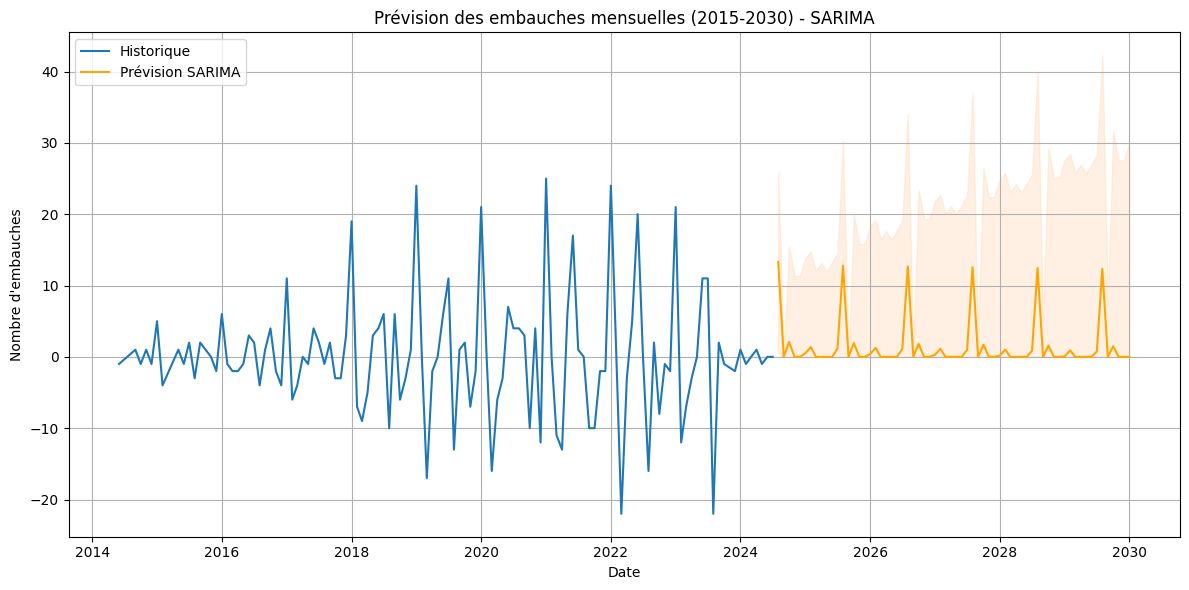

19:51:46 - cmdstanpy - INFO - Chain [1] start processing
19:51:46 - cmdstanpy - INFO - Chain [1] done processing


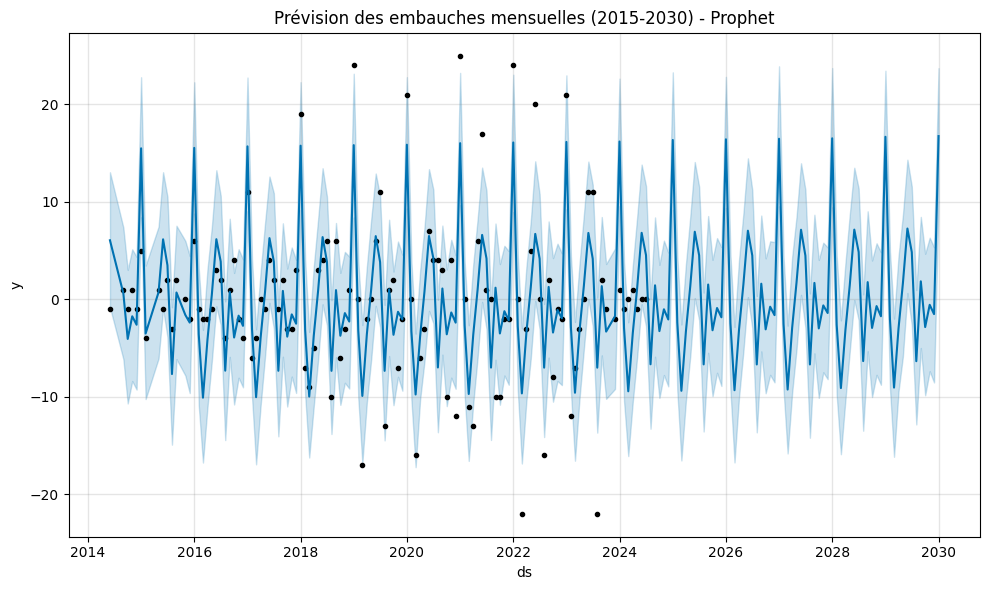

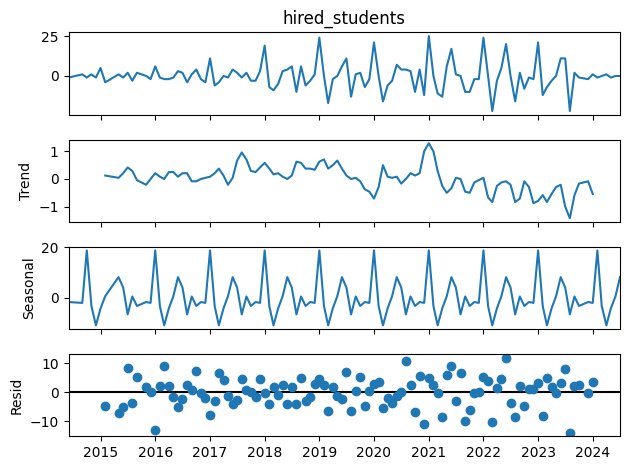

        Date  Prévision  Borne Inf  Borne Sup
0 2024-08-01  13.310136   0.565125  26.055148
1 2024-09-01   0.000000   0.000000   0.000000
2 2024-10-01   2.087381   0.000000  15.450824
3 2024-11-01   0.000000   0.000000  11.326965
4 2024-12-01   0.000000   0.000000  11.377705
5 2025-01-01   0.514786   0.000000  13.881797
6 2025-02-01   1.365812   0.000000  14.732907
7 2025-03-01   0.000000   0.000000  12.049045
8 2025-04-01   0.000000   0.000000  13.175157
9 2025-05-01   0.000000   0.000000  12.002997


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sqlalchemy import create_engine

# 📦 Connexion PostgreSQL
user = 'postgres'
password = 'sarra'
host = 'localhost'
port = '5432'
database = 'DWHF'
connection_string = f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}'
conn = create_engine(connection_string)

# 📥 Requête SQL
query = """
SELECT 
    dd."full_date" AS hire_date
FROM "fact_employability" fe
JOIN "dim_date" dd ON fe."First_job_Date_FK" = dd."Date_PK"
WHERE dd."full_date" IS NOT NULL
  AND dd."full_date" >= '2014-01-01';
"""

df = pd.read_sql(query, conn)
conn.dispose()

# 📅 Préparation des données temporelles
df['hire_month'] = pd.to_datetime(df['hire_date']).dt.to_period('M').dt.to_timestamp()
df_grouped = df.groupby('hire_month').size().reset_index(name='hired_students')
df_grouped.set_index('hire_month', inplace=True)
df_grouped.index = pd.DatetimeIndex(df_grouped.index)
#df_grouped.index.freq = 'MS'  # Fix pour statsmodels

# 📌 Suppression des Outliers (Méthode IQR)
Q1 = df_grouped['hired_students'].quantile(0.25)
Q3 = df_grouped['hired_students'].quantile(0.75)
IQR = Q3 - Q1
seuil_sup = Q3 + 1.5 * IQR
df_grouped['hired_students'] = np.where(df_grouped['hired_students'] > seuil_sup, seuil_sup, df_grouped['hired_students'])

# 📈 Vérification Stationnarité (ADF Test)
adf_pvalue = adfuller(df_grouped['hired_students'])[1]
if adf_pvalue > 0.05:
    print("🔄 Série non stationnaire, application d'une différenciation...")
    df_grouped['hired_students'] = df_grouped['hired_students'].diff()
    df_grouped.dropna(inplace=True)

# ✅ Vérification du nombre de mois
if len(df_grouped) < 24:
    print(f"❌ Pas assez de données. Mois disponibles : {len(df_grouped)} (minimum 24 requis).")
else:
    print(f"✅ Nombre de mois disponibles : {len(df_grouped)}")

    # 📈 Holt-Winters (Additive pour éviter les erreurs de valeurs négatives)
    holt_model = ExponentialSmoothing(
        df_grouped,
        trend='add',
        seasonal='add',
        seasonal_periods=12,
        initialization_method='estimated'
    ).fit()

    # 📈 SARIMA (Paramètres optimisés)
    sarima_model = SARIMAX(
        df_grouped,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    # 📅 Prévisions
    last_date = df_grouped.index[-1]
    end_date = pd.to_datetime("2030-01-01")
    months_to_predict = (end_date.year - last_date.year) * 12 + (end_date.month - last_date.month)
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=months_to_predict, freq='MS')

    forecast_result = sarima_model.get_forecast(steps=months_to_predict)
    forecast = forecast_result.predicted_mean.clip(lower=0)
    conf_int = forecast_result.conf_int().clip(lower=0)

    # 📊 Visualisation SARIMA
    plt.figure(figsize=(12, 6))
    plt.plot(df_grouped, label='Historique')
    plt.plot(forecast_dates, forecast, label='Prévision SARIMA', color='orange')
    plt.fill_between(forecast_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='peachpuff', alpha=0.4)
    plt.title("Prévision des embauches mensuelles (2015-2030) - SARIMA")
    plt.xlabel("Date")
    plt.ylabel("Nombre d'embauches")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 📈 Prophet
    try:
        from prophet import Prophet
        df_prophet = df_grouped.reset_index().rename(columns={'hire_month': 'ds', 'hired_students': 'y'})
        prophet_model = Prophet(yearly_seasonality=True)
        prophet_model.fit(df_prophet)

        future = prophet_model.make_future_dataframe(periods=months_to_predict, freq='MS')
        forecast_prophet = prophet_model.predict(future)

        prophet_model.plot(forecast_prophet)
        plt.title("Prévision des embauches mensuelles (2015-2030) - Prophet")
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("⚠️ Prophet n'est pas installé. Utilise : pip install prophet")

    # 📊 Décomposition Saisonnière (Sécurisée)
    try:
        result = seasonal_decompose(df_grouped['hired_students'], model='additive', period=12)
        result.plot()
        plt.tight_layout()
        plt.show()
    except ValueError:
        print("⚠️ Impossible de faire la décomposition : données insuffisantes ou NaN résiduels.")

    # 📄 Export des Résultats
    result_df = pd.DataFrame({
        'Date': forecast_dates,
        'Prévision': forecast.values,
        'Borne Inf': conf_int.iloc[:, 0].values,
        'Borne Sup': conf_int.iloc[:, 1].values
    })

    print(result_df.head(10))
    # Pour exporter : result_df.to_csv("previsions_embauche.csv", index=False)
